# Bayesball: Bayesian analysis of batting average

One of the topics in data science or statistics I found interesting, but having difficulty understanding is Bayesian analysis. During the course of my General Assembly’s Data Science Immersive boot camp, I have had a chance to explore Bayesian statistics, but I really think I need some review and reinforcement.

This is my personal endeavour to have a better understanding of Bayesian thinking, and how it can be applied to real-life cases.

For this post, I am mainly inspired by a Youtube series by Rasmus Bååth, “Introduction to Bayesian data analysis”. He is really good at giving you an intuitive understanding of Bayesian analysis, not by bombarding you with all the complicated formulas, but by providing you with a thought-process of Bayesian statistics.
https://www.youtube.com/user/rasmusab/feed

The topic I chose for this post is baseball. To be honest, I’m not a big sports fan. I rarely watch sports. As a Korean, baseball is the most famous sports in Korea, and I believe there are some Korean players in MLB as well. It’s a bit embarrassing to admit, but I have heard of Chan-Ho Park, but that’s about it.

Then why choose baseball?

"I don't know whether you know it, but baseball's appeal is decimal points. No other sport relies as totally on continuity, statistics, orderliness of these. Baseball fans pay more attention to numbers than CPAs." - Sportswriter Jim Murray

They say baseball is probably the world’s best documented sports. The history has cumulated records in the past hundred years of the baseball statistics. However having collected stats alone doesn’t make baseball interesting in terms of statistics. Maybe the more important aspect is the individual nature of the game. For example, during an at-bat, who is playing in the outfield has very little effect on whether or not the batter can hit a home run. In other sports, especially football and basketball, the meaning of individual statistics can be diluted by the importance of what is going on elsewhere on the field or the court. This is what makes baseball stats useful for player comparison.

Baseball stats consist of numerous metrics, some of them straight-forward, some of them quite advanced. The metric I chose to take a look at is batting average(AVG). In baseball, the batting average (BA) is defined by the number of hits divided by at bats. It is usually reported to three decimal places. https://en.wikipedia.org/wiki/List_of_Major_League_Baseball_career_batting_average_leaders

There can be criticism on batting average, but according to C. Trent Rosecrans, “Still, what batting average does have over all the other statistics is history and context. We all know what a .300 hitter is, we know how bad a .200 hitter is and how great a .400 hitter is.”
https://www.cbssports.com/mlb/news/what-is-the-best-offensive-stat/

It seems like the regular season hasn’t started yet, and will start soon (29th of March). But there’s spring training. In Major League Baseball (MLB), spring training is a series of practices and exhibition games preceding the start of the regular season.

The questions I would try to answer are as follows:
- How I should interpret batting average from 2018 spring training
- How can I compare two players on their batting average

Before I jump into code, I will briefly touch on what Rasmus Bååth explained in his videos.

We first need three things to implement Bayesian analysis.
1. Data
2. Generative Model
3. Prior

In my case, the data will be the batting average records from 2018 spring training. The data is simply what we observed.

A Generative Model is the model that generates data when given parameters as input. The parameters are values you'll need to generate a distribution. For example, if you know the mean and the standard deviation, you can easily generate normally distributed data of your chosen size by running below code.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
from bs4 import BeautifulSoup

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

(array([  8.,  29., 104., 138., 205., 229., 157.,  74.,  46.,  10.]),
 array([-2.89453590e-01, -2.31509431e-01, -1.73565271e-01, -1.15621112e-01,
        -5.76769530e-02,  2.67206226e-04,  5.82113654e-02,  1.16155525e-01,
         1.74099684e-01,  2.32043843e-01,  2.89988002e-01]),
 <a list of 10 Patch objects>)

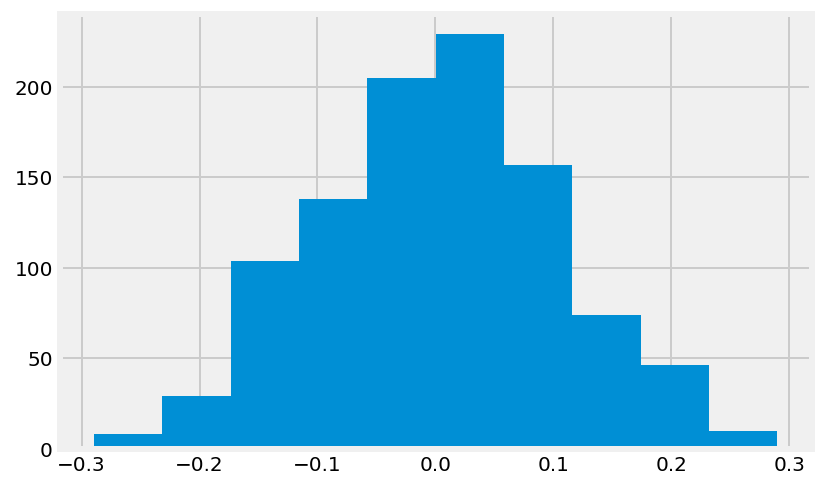

In [2]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
plt.hist(s)

However, in the case of Bayesian analysis, we inverse the generative model and try to infer parameters with observed data.

![title](bs_img/gm_01.png)

Finally, Prior is the information that the model has before seeing the data. Is any probability equally likely? Or do we have some prior data that we can utilise? Or is there any educated guess that we can make?

I will first define a function to scrape Fox Sports' stats page for a player. I defined it as to be able to extract BATTING stats for either spring traning or regular season.

![title](bs_img/fs_01.png)

In [3]:
def batting_stats(url,season):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')
    table = soup.find_all("table",{"class": "wisbb_standardTable tablesorter"})[0]
    table_head = soup.find_all("thead",{"class": "wisbb_tableHeader"})[0]
    if season == 'spring':
        row_height = len(table.find_all('tr')[:-1])
    else:
        row_height = len(table.find_all('tr')[:-2])
    result_df = pd.DataFrame(columns=[row.text.strip() for row in table_head.find_all('th')], index = range(0,row_height)) 
    
    row_marker = 0
    for row in table.find_all('tr')[:-1]:
        column_marker = 0
        columns = row.find_all('td')
        for column in columns:
            result_df.iat[row_marker,column_marker] = column.text.strip()
            column_marker += 1
        row_marker += 1
    return result_df

![title](bs_img/fs_02.png)

The above screen is spring training stats page for NY Mets (As I have already admitted, I know little about baseball, and I chose NY Mets because I liked the logo). If you arrange the players by their batting average (AVG), you can see Dominic Smith (DS) as the first, and Gavin Cecchini (GC) as the second. Are they good players? I don't know. But by looking at the AVG only, DS is the best with 1.000 AVG. 

But by some googling, I found out that "In recent years, the league-wide batting average has typically hovered around .260". http://m.mlb.com/glossary/standard-stats/batting-average
If so, then the AVG for DS and GC seems too high. By further looking at At-Bats (AB), Hits (H) of both players, it is clear that DS had only 1 AB and CS had 7.

And by looking further at AB for other players, the highest AB is 13 for 2018, and in 2017 the maximum AB is 60 within NY Mets.

## Scenario 1

Let's assume that I know nothing about their past performance, and the only data I observed is 2018 spring training. And I don't know what value range I should expect from AVG. Based on this, how should I interpret the stats from 2018 spring training? 

Let's first scrape the spring training stats for DS.

In [4]:
ds_url_st = "https://www.foxsports.com/mlb/dominic-smith-player-stats?seasonType=3"
dominic_smith_spring = batting_stats(ds_url_st,'spring')

In [5]:
dominic_smith_spring.iloc[-1]

BATTING     2018
Team         NYM
G              1
PA             2
AB             1
R              2
H              1
2B             0
3B             0
HR             0
RBI            0
SB             0
CS             0
BB             0
SO             0
AVG        1.000
OBP        1.000
SLG        1.000
OPS        2.000
Name: 4, dtype: object

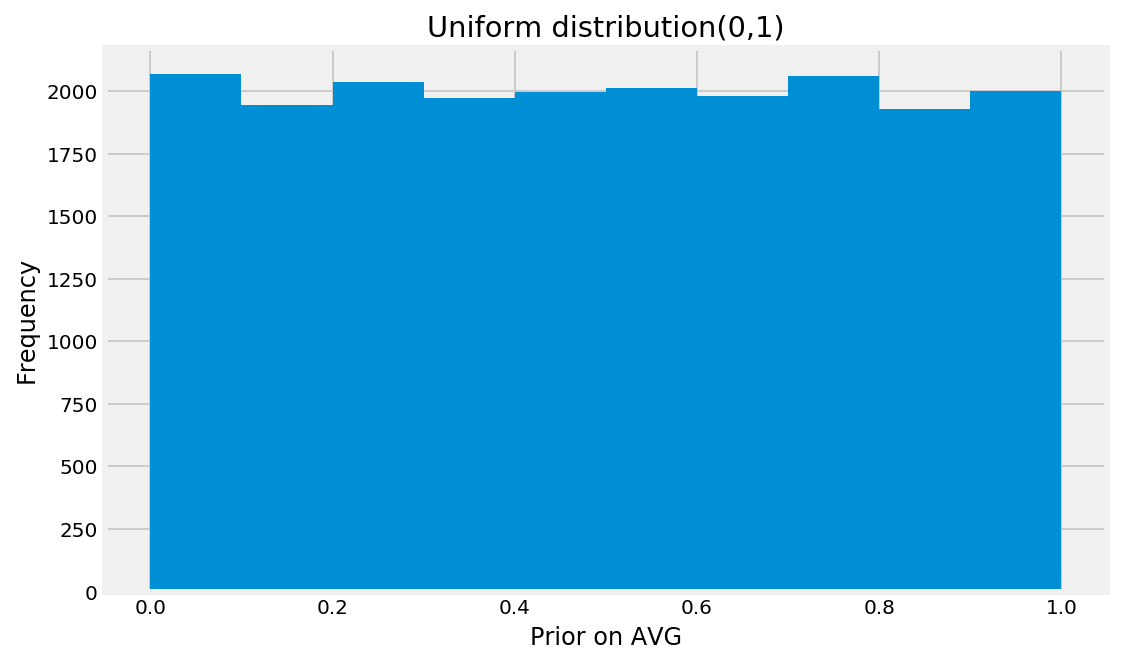

In [6]:
n_draw = 20000
prior_ni = pd.Series(np.random.uniform(0, 1, size = n_draw)) 
plt.figure(figsize=(8,5))
plt.hist(prior_ni)
plt.title('Uniform distribution(0,1)')
plt.xlabel('Prior on AVG')
plt.ylabel('Frequency')

The prior represents our beliefs before we see the data. In the above distribution, any probability is almost equally likely (There are slight differences due to the random generation). Thus this means I know nothing about the player, and I don’t even have any educated guess to make about AVG. I assume that 0.000 AVG is equally like as 1.000 AVG or any other probability between 0 and 1.

Now the data we observed says there was 1 AB, and 1 H, hence 1.000 AVG. This can be represented by Binomial distribution. A random variable X that has a binomial distribution represents the number of successes in a sequence of n independent yes/no trials, each of which yields success with probability p. In case of AVG, AVG is the probability of success, AB is the number of trials, and H is the number of success.

Keeping these in mind, we can define our inverse generative model. 

We will randomly pick one probability value from the uniform distribution we defined, and use this value as parameter for our generative model. Let's say the value we randomly picked is 0.230, this means 23% chance of success in Binomial distribution. The number of trial is 1 (DS has 1 AB), and if the result of the generative model matches the result we observed (in this case, DS has 1 H), then we keep the probability value 0.230. If we repeat this generation and filtering, we will finally get a distribution of probability that has generated the same result as we observed.

This becomes our Posterior.

Number of draws left: 10056, Posterior mean: 0.665, Posterior median: 0.706, Posterior 95% quantile interval: 0.160-0.987


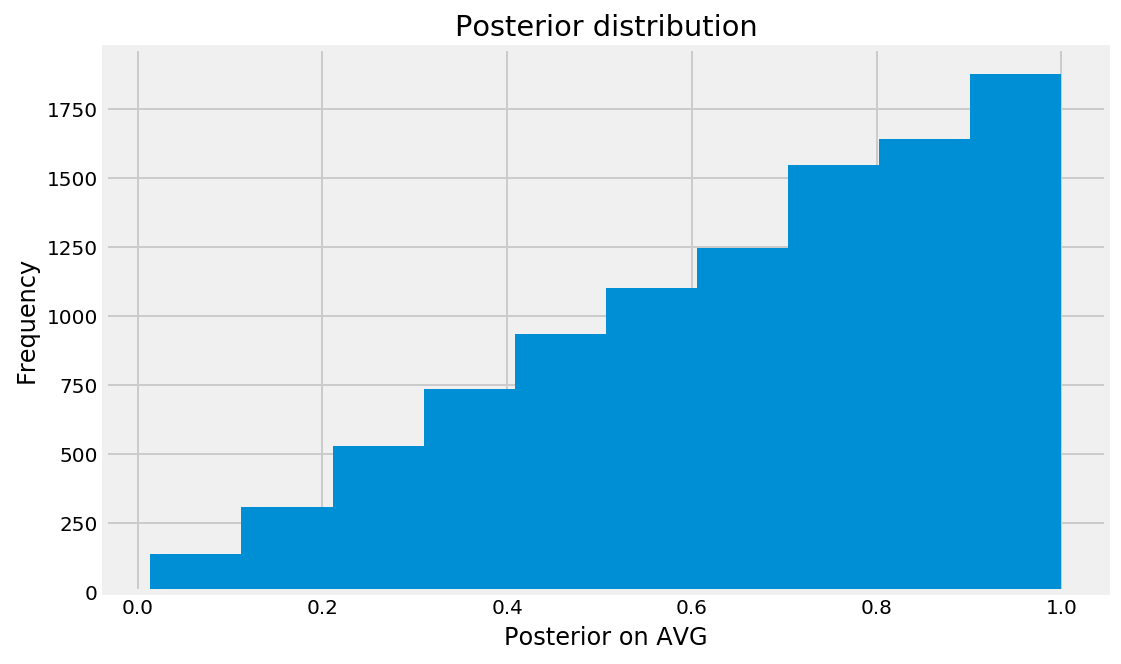

In [7]:
def posterior(n_try, k_success, prior):
    hit = list()
    for p in prior:
        hit.append(np.random.binomial(n_try, p))
    posterior = prior[list(map(lambda x: x == k_success, hit))]
    plt.figure(figsize=(8,5))
    plt.hist(posterior)
    plt.title('Posterior distribution')
    plt.xlabel('Posterior on AVG')
    plt.ylabel('Frequency')
    print('Number of draws left: %d, Posterior mean: %.3f, Posterior median: %.3f, Posterior 95%% quantile interval: %.3f-%.3f' % 
      (len(posterior), posterior.mean(), posterior.median(), posterior.quantile(.025), posterior.quantile(.975)))

ds_n_trials = int(dominic_smith_spring[['AB','H']].iloc[-1][0])
ds_k_success = int(dominic_smith_spring[['AB','H']].iloc[-1][1])
posterior(ds_n_trials, ds_k_success, prior_ni)

95% quantile interval in posterior distribution is called credible interval, and should be seen slightly different from confidence interval in Frequentists' sense. There is another credible interval you can use, and I will get back to this when I mention Pymc3.

One major distinction between Bayesian's credible interval and Frequentist's confidence interval is their interpretation. The Bayesian probability reflects a person’s subjective beliefs. Following this approach, we can make the claim that true parameter is inside a credible interval with measurable probability. This property is appealing because it enables you to make a direct probability statement about parameters. Many people find this concept to be a more natural way of understanding a probability interval, which is also easier to explain. A confidence interval, on the other hand, enables you to make a claim that the interval covers the true parameter. If we gather a new sample, and calculate the confidence interval, and repeat this many times, 95% of those intervals we calculated will have true AVG value within the interval.


Credible Interval: "Given our observed data, there is a 95% probability that the true value of AVG falls within the credible interval" 

Confidence Interval: "There is a 95% probability that when I compute confidence interval from data of this sort, the true value of AVG will fall within the confidence interval."

Note the difference: the credible interval is a statement of probability about the parameter value given fixed bounds. The confidence interval is a probability about the bounds given a fixed parameter value.

Often in real-life, what we would like to know is about the true parameters not about the bounds, in that case, Bayesian credible interval is the right way to go. In this case we are interested in true AVG of the player.

This means that I am 95% certain that DS true AVG will be somewhere between 0.155 to 0.987. But that is a very braod statement to make. In other words, I am not quite certain about the true AVG of DS, after I observe just one trial with no prior knowledge.

## Scenario 2

For the second scenario, let's assume that we know spring training stats from previous year.

In [8]:
dominic_smith_spring.iloc[-2:]

,BATTING,Team,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,AVG,OBP,SLG,OPS
3,2017,NYM,20,42,36,4,6,1,0,0,4,0,0,5,13,.167,.286,.194,.480
4,2018,NYM,1,2,1,2,1,0,0,0,0,0,0,0,0,1.000,1.000,1.000,2.000


Now we have 2017 spring training stats, and our prior should reflect this knowledge. This is not a uniform distribution anymore since we know that in 2017 spring training, DS’s AVG was 0.167.

The Beta distribution is a continuous probability distribution having two parameters, alpha and beta. One of its most common uses is to model one’s uncertainty about the probability of success of an experiment. In particular, the conditional distribution of X, conditional on having observed k successes out of n trials, is a Beta distribution with parameters k+1 as alpha and n−k+1 as beta.
https://www.statlect.com/probability-distributions/beta-distribution

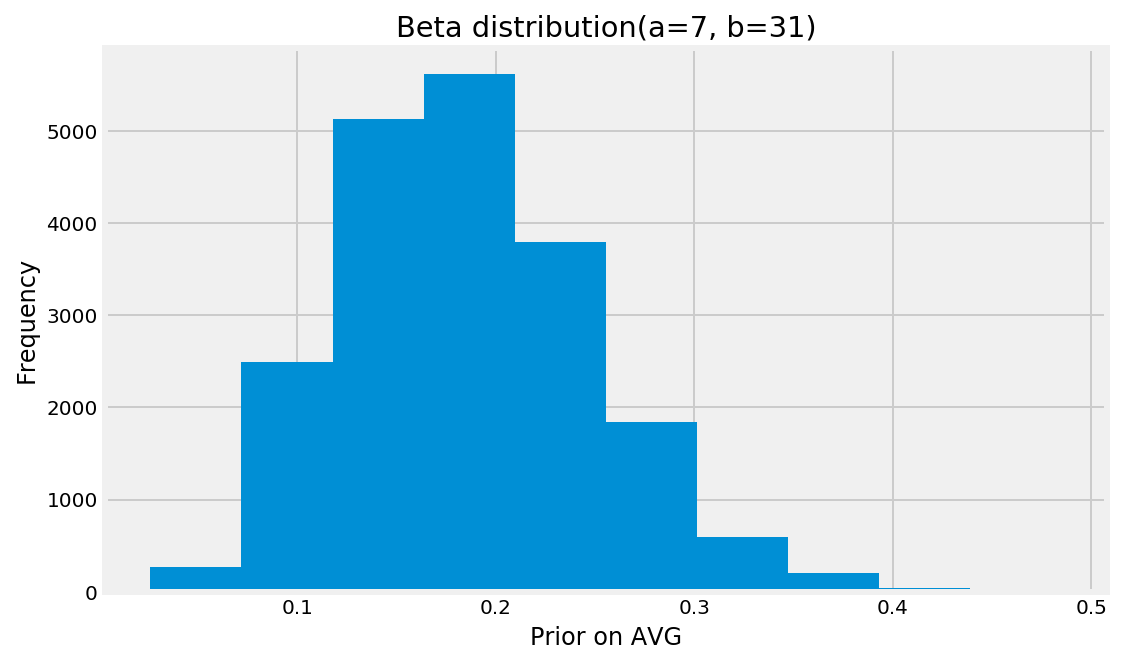

In [9]:
n_draw = 20000
prior_trials = int(dominic_smith_spring.iloc[3].AB)
prior_success = int(dominic_smith_spring.iloc[3].H)
prior_i = pd.Series(np.random.beta(prior_success+1, prior_trials-prior_success+1, size = n_draw)) 
plt.figure(figsize=(8,5))
plt.hist(prior_i)
plt.title('Beta distribution(a=%d, b=%d)' % (prior_success+1,prior_trials-prior_success+1))
plt.xlabel('Prior on AVG')
plt.ylabel('Frequency')

Number of draws left: 3695, Posterior mean: 0.205, Posterior median: 0.199, Posterior 95% quantile interval: 0.097-0.343


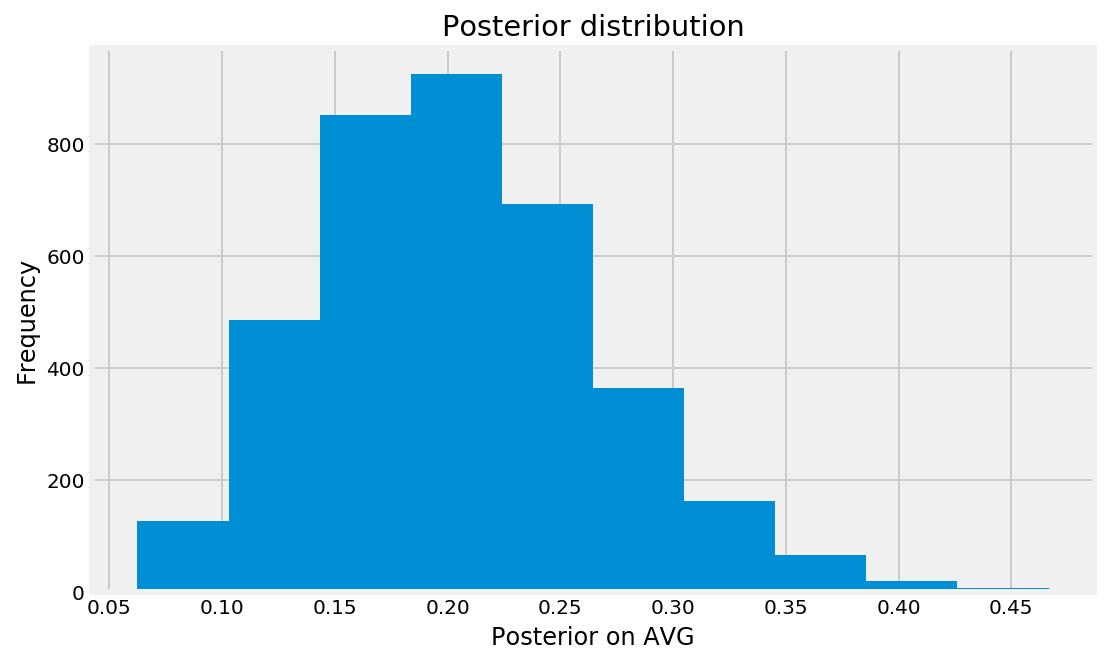

In [10]:
posterior(ds_n_trials, ds_k_success, prior_i)

The 95% quantile region has been narrowed compared to the posterior with the uniform prior in Scenario 1. Now I can say that I am 95% certain that the true AVG of DS will lie between 0.095 to 0.340. However, considering that above 0.300 AVG is often called best hitters, the statement means that the player can be either worst hitter or the best hitter. We need more data to narrow our region of credibility.

## Scenario 3

For this scenario, let's assume that I not only have stats from 2017 spring training, but also stats from 2017 regular season. How does this affect my statement after I got the posterior?

In [11]:
ds_url = "https://www.foxsports.com/mlb/dominic-smith-player-stats?seasonType=1"
dominic_smith_reg = batting_stats(ds_url,'regular')
dominic_smith_reg

,BATTING,Team,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,AVG,OBP,SLG,OPS
0,2017,NYM,49,183,167,17,33,6,0,9,26,0,0,14,49,.198,.262,.395,.657


In [12]:
dominic_smith = dominic_smith_reg.append(dominic_smith_spring.iloc[3], ignore_index=True)
dominic_smith

,BATTING,Team,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,AVG,OBP,SLG,OPS
0,2017,NYM,49,183,167,17,33,6,0,9,26,0,0,14,49,.198,.262,.395,.657
1,2017,NYM,20,42,36,4,6,1,0,0,4,0,0,5,13,.167,.286,.194,.480


In [13]:
ds_prior_trials = pd.to_numeric(dominic_smith.AB).sum()

In [14]:
ds_prior_success = pd.to_numeric(dominic_smith.H).sum()

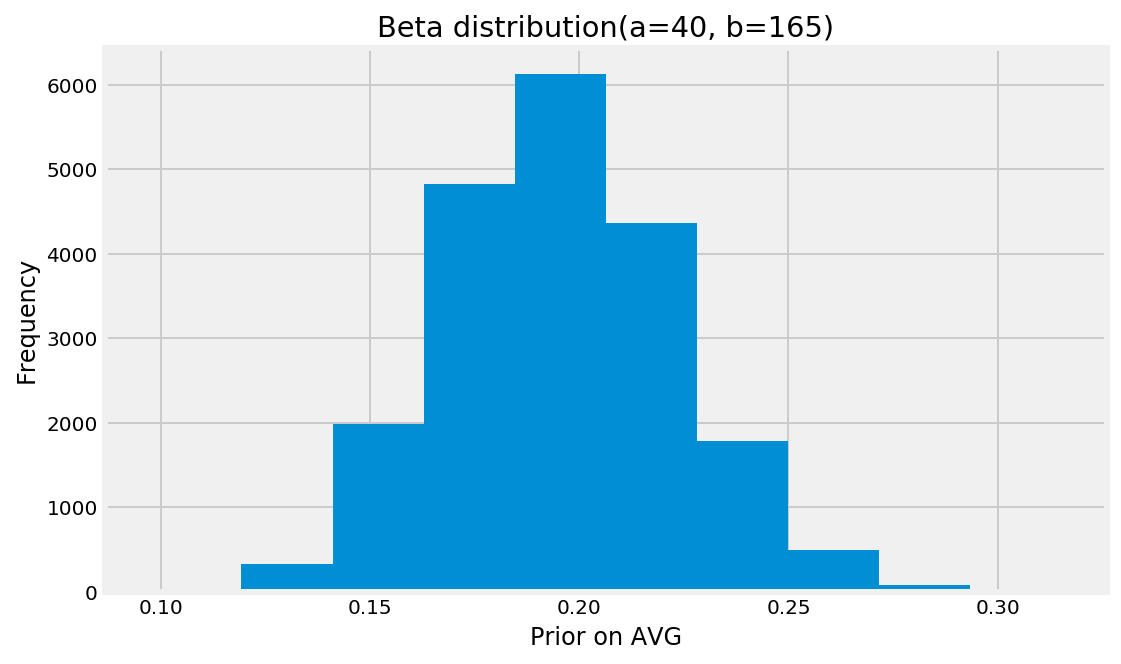

In [15]:
n_draw = 20000
prior_i_02 = pd.Series(np.random.beta(ds_prior_success+1, ds_prior_trials-ds_prior_success+1, size = n_draw)) 
plt.figure(figsize=(8,5))
plt.hist(prior_i_02)
plt.title('Beta distribution(a=%d, b=%d)' % (ds_prior_success+1,ds_prior_trials-ds_prior_success+1))
plt.xlabel('Prior on AVG')
plt.ylabel('Frequency')

Number of draws left: 3847, Posterior mean: 0.199, Posterior median: 0.198, Posterior 95% quantile interval: 0.148-0.256


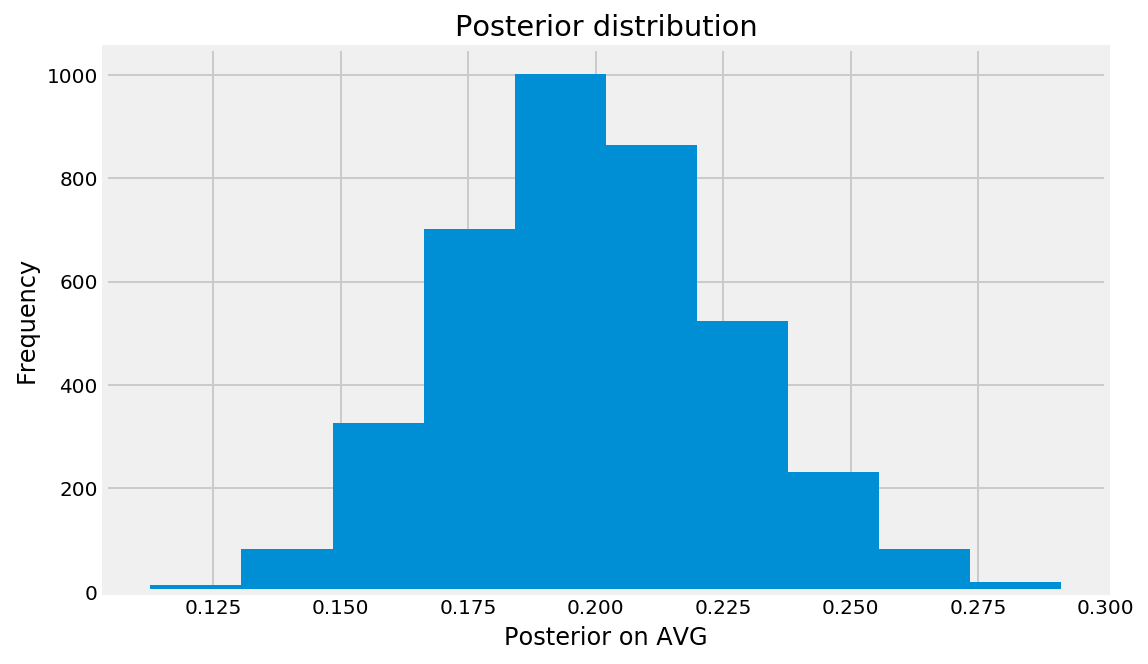

In [16]:
posterior(ds_n_trials, ds_k_success, prior_i_02)

Now I can say that I am 95% certain that the true AVG of DS will lie between 0.146 to 0.258. It may not be pin-point but compared to Scenario 1 and 2, the credible interval is much narrower.

## Scenario 4

I want to compare two players and see who's better in terms of AVG. The data I observed is results from 2018 spring training, and the prior knowledge I have is of 2017 spring training and regualr season. Now I want to compare DS to GC.

Up until Scenario 3, I simulated the sampling by rejecting all the parameters which yielded the result different from what I observed. But this type of random sample generation and filtering is often computationally expensive, and slow to run. But luckily, there’s a tool that we can use to enable the sampler spends more time in regions of high probability, raising efficiency. Probabilistic programming tools such as Pymc3 can efficiently handle sampling procedure by making use of clever algorithms such as HMC-NUTS. http://blog.fastforwardlabs.com/2017/01/30/the-algorithms-behind-probabilistic-programming.html

In [17]:
gc_url_st = "https://www.foxsports.com/mlb/gavin-cecchini-player-stats?seasonType=3"
gc_url_reg = "https://www.foxsports.com/mlb/gavin-cecchini-player-stats?seasonType=1"
gavin_cecchini_spring = batting_stats(gc_url_st,'spring')
gavin_cecchini_reg = batting_stats(gc_url_reg,'regular')

In [18]:
gavin_cecchini_spring

,BATTING,Team,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,AVG,OBP,SLG,OPS
0,2017,NYM,11,29,27,6,9,2,0,1,3,1,1,2,5,.333,.379,.519,.898
1,2018,NYM,6,14,11,3,5,1,0,2,5,1,0,2,2,.455,.571,1.091,1.662


In [19]:
gc_n_trials = int(gavin_cecchini_spring.iloc[1].AB)
gc_k_success = int(gavin_cecchini_spring.iloc[1].H)

In [20]:
gc_prior = pd.DataFrame(gavin_cecchini_reg.iloc[1]).transpose().append(gavin_cecchini_spring.iloc[0])
gc_prior

,BATTING,Team,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,AVG,OBP,SLG,OPS
1,2017,NYM,32,82,77,4,16,2,0,1,7,0,1,4,19,.208,.256,.273,.529
0,2017,NYM,11,29,27,6,9,2,0,1,3,1,1,2,5,.333,.379,.519,.898


In [21]:
gc_prior_trials = pd.to_numeric(gc_prior.AB).sum()
gc_prior_success = pd.to_numeric(gc_prior.H).sum()

In [22]:
def observed_data_generator(n_try,observed_data):
    result = np.ones(observed_data)
    fails = n_try - observed_data
    result = np.append(result, np.zeros(fails))
    return result

In [23]:
ds_observed = observed_data_generator(ds_n_trials,ds_k_success)
gc_observed = observed_data_generator(gc_n_trials,gc_k_success)

In [24]:
import pymc3 as pm
with pm.Model() as model_a:    
    D_p = pm.Beta('DS_AVG', ds_prior_success+1, ds_prior_trials-ds_prior_success+1)
    G_p = pm.Beta('GC_AVG', gc_prior_success+1, gc_prior_trials-gc_prior_success+1)
    DS = pm.Bernoulli('DS', p=D_p, observed=ds_observed)
    GC = pm.Bernoulli('GC', p=G_p, observed=gc_observed) 
    DvG = pm.Deterministic('DvG', D_p - G_p)
    start = pm.find_MAP()
    trace = pm.sample(10000, start=start)

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
logp = -5.4306, ||grad|| = 1.803: 100%|██████████| 8/8 [00:00<00:00, 1223.81it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/anaconda2/lib/python2.7/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 10500/10500 [00:07<00:00, 1433.37it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x118cab090>,
      dtype=object)

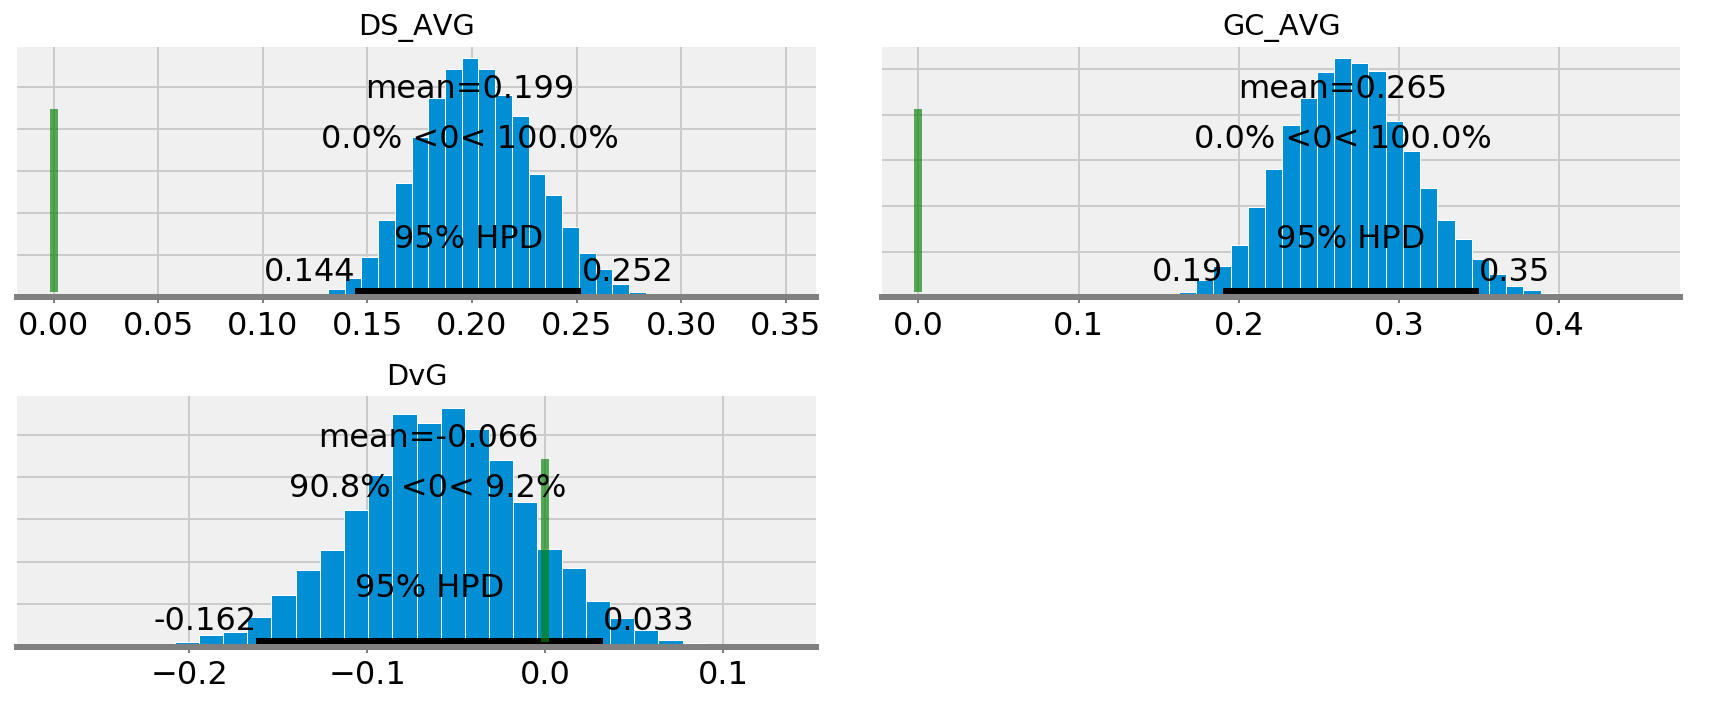

In [25]:
pm.plot_posterior(trace, varnames=['DS_AVG','GC_AVG','DvG'],ref_val=0)

If we plot the posterior distributions of DS_AVG, GC_AVG, and DvG (DS_AVG - GC_AVG) using plot_posterior function in Pymc3, we see the term HPD instead of quantile. Highest Probability Density (HPD) interval is another type of credible interval we can use with posteriors. HPD interval chooses the narrowest interval, which will involve choosing those values of highest probability density including the mode.

Again I found another post by Rasmus Bååth provides easy to understand visual comparison of quantile interval and highest density interval.
http://www.sumsar.net/blog/2014/10/probable-points-and-credible-intervals-part-one/
Below is the mode and the highest density interval covering 95% of the probability density for the six different posterior distributions.

![title](bs_img/hpdi_01.png)

The quantile interval includes the median, and having 50% of the probability to its left and 50% to its right and the quantile interval leaving, say, 2.5% probability on either side (in case of 95% credible interval).

![title](bs_img/mqi_01.png)

In the case of batting average for DS and GC, it looks like the mode and the median is not that different, and if so HPD interval will be similar to quantile interval. Let's see how they look.

In [26]:
pm.summary(trace)


DS_AVG:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.199            0.028            0.000            [0.144, 0.252]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.147          0.179          0.198          0.217          0.256


GC_AVG:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.265            0.041            0.000            [0.190, 0.350]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.189          0.237          0.263          0.291          0.349


DvG:

  Mean             SD               MC Error         95% HPD interval
  -------------------------

We can see that both for DS and GC, HPD interval and quantile interval is either exactly the same or slighty different in decimal places.

The question I wanted to answer was who is the better player in terms of AVG, and I should say I can't be certain. At least, I can't be 95% certain that these two players are different in terms of AVG. The difference I calculated and plotted shows that the difference of AVG of two players (DS - GC, so if DvG is more positive then it means DS is better, else if DvG is more negative then it means GC is better), can be somewhere between -0.162 to 0.033.

This interval include 0.000 which represents there is no difference between two players' AVG. Thus, there are evidences that GC is better than DS (since the DvG posterior distribution has larger region in negative area than in the positive area), but I can't be 95% certain that these two players are different in terms of AVG.